In [2]:
import tensorflow as tf
from tensorflow.keras import (layers)

In [3]:
x = tf.random.normal((2,5,5,11))
print(f"first row, first column 11 channel values : {x[0,0,0,:]}")

first row, first column 11 channel values : [-0.491657    0.20159854 -0.71079797 -0.7393285   0.3586726   1.5548885
 -0.4258876   0.20275365  0.7992533  -1.4394389  -0.05945982]


In [4]:
conv_layer =  layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")
new_x =conv_layer(x)
print(f"new_x shape : {tf.shape(new_x)}")

new_x shape : [2 5 5 3]


In [5]:
print(f"new_x one value : {new_x[0,0,0,:]}")

new_x one value : [0. 0. 0.]


In [6]:
x2=conv_layer(x)
print(f"x2 : {x2[0,0,0,:]}")

x2 : [0. 0. 0.]


In [7]:
x3 = conv_layer(x)
print(f"x3 : {x3[0,0,0,:]}")

x3 : [0. 0. 0.]


# Diffusion model in torch

In [8]:
IMAGE_SIZE = 64
BATCH_SIZE = 64
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

In [9]:
import torch

print(torch.log(torch.exp(torch.tensor(2.0))))
print(torch.linspace(torch.log(torch.tensor(1.0)), torch.log(torch.tensor(1000.0)),16))

tensor(2.)
tensor([0.0000, 0.4605, 0.9210, 1.3816, 1.8421, 2.3026, 2.7631, 3.2236, 3.6841,
        4.1447, 4.6052, 5.0657, 5.5262, 5.9867, 6.4472, 6.9078])


In [10]:
def sinusoidal_embedding(x):
    """
    param x: (N,1,1,1) shape random normal noise
    """
    frequencies = torch.linspace(torch.log(torch.tensor(1.0)),torch.log(torch.tensor(1000.0)),16)
    frequencies = frequencies.unsqueeze(0).unsqueeze(2).unsqueeze(3)
    angular_speeds = 2*torch.pi*torch.exp(frequencies)*x
    return torch.cat((torch.sin(angular_speeds),torch.cos(angular_speeds)),dim=1)


In [11]:
noise=torch.randn((5,1,1,1))
sin_embeddings = sinusoidal_embedding(noise)

In [12]:
embeddings = sin_embeddings
print(embeddings.shape)

torch.Size([5, 32, 1, 1])


In [13]:
import torch.nn as nn

upsampled_noise = nn.Upsample(scale_factor=64,mode="nearest")(embeddings)



In [14]:
upsampled_noise.shape

torch.Size([5, 32, 64, 64])

In [15]:
upsampled_noise[0,0,:,:]

tensor([[-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328],
        [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328],
        [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328],
        ...,
        [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328],
        [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328],
        [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328]])

In [16]:
noisy_image = torch.randn(5,3,64,64)

In [17]:
x = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3, padding=1, stride=1)(noisy_image)
print(x.shape)

torch.Size([5, 32, 64, 64])


In [18]:
x = torch.cat([upsampled_noise,x],dim=1)
print(x.shape)

torch.Size([5, 64, 64, 64])


In [19]:
x = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=1)(x)
print(x.shape)

torch.Size([5, 32, 64, 64])


In [20]:
x = nn.AvgPool2d(kernel_size=2)(x)
print(x.shape)

torch.Size([5, 32, 32, 32])


In [21]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def ResidualBlock(n_channels):
    def apply(x):
        in_channels = x.shape[1]
        if n_channels==in_channels:
            residual = x
        else:
            residual = nn.Conv2d(in_channels=in_channels, out_channels=n_channels, kernel_size=1)(x)
        x=nn.BatchNorm2d(num_features=in_channels,affine=False)(x)
        x = nn.Conv2d(in_channels=in_channels,out_channels=n_channels, kernel_size=3, padding=1, stride=1)(x)
        x = Swish()(x)
        x = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, padding=1, stride=1)(x)
        return x + residual
    return apply

In [22]:
x = ResidualBlock(64)(x)
print(x.shape)

torch.Size([5, 64, 32, 32])


In [23]:
def DownBlock(n_channels,block_depth):
    def apply(x):
        x, skips = x

        for _ in range(block_depth):
            x = ResidualBlock(n_channels)(x)
            skips.append(x)
        x = nn.AvgPool2d(kernel_size=2)(x)
        return x
    return apply

In [24]:
skips=[]
x = DownBlock(96,2)([x,skips])
print(x.shape)

torch.Size([5, 96, 16, 16])


In [25]:
def UpBlock(n_channels, block_depth):
    def apply(x):
        x, skips = x
        x = nn.Upsample(scale_factor=2,mode="bilinear")(x)
        for _ in range(block_depth):
            x = torch.cat([x,skips.pop()],dim=1)
            x = ResidualBlock(n_channels)(x)
        return x
    return apply

In [26]:
x = UpBlock(96,2)([x,skips])

In [27]:
print(x.shape)

torch.Size([5, 96, 32, 32])


In [28]:
class Unet(nn.Module):
    def __init__(self, in_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
        self.upsample1 = nn.Upsample(scale_factor=64, mode="nearest")

        self.skips=[]

        self.downblock1 = DownBlock(32,2)
        self.downblock2 = DownBlock(64,2)
        self.downblock3 = DownBlock(96,2)

        self.residual1 = ResidualBlock(128)
        self.residual2 = ResidualBlock(128)

        self.upblock1 = UpBlock(96,2)
        self.upblock2 = UpBlock(64, 2)
        self.upblock3 = UpBlock(32,2)
        
        self.conv_last = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)
    
    def forward(self, x):
        noisy_images,noise_variances = x
        noise_embeddings = sinusoidal_embedding(noise_variances)        
        noise_embeddings = self.upsample1(noise_embeddings)
        
        x = self.conv1(noisy_images)
        x = torch.cat([x, noise_embeddings], dim=1)

        x = self.downblock1([x, self.skips])
        x = self.downblock2([x, self.skips])
        x = self.downblock3([x, self.skips])

        x = self.residual1(x)
        x = self.residual2(x)

        x = self.upblock1([x, self.skips])
        x = self.upblock2([x, self.skips])
        x = self.upblock3([x, self.skips])

        x = self.conv_last(x)

        return x


In [29]:
N=5
noise_variances = torch.randn(N,1,1,1)
noisy_images = torch.randn(N, 3, 64, 64)

unet = Unet(in_channels=3)

out = unet([noisy_image, noise_variances])

print(out.shape)

torch.Size([5, 3, 64, 64])


# Normalization layer

In [30]:
import torch

# Simulate some input data (batch_size, num_channels, height, width)
N, C, H, W = 5, 3, 64, 64
dummy_train = torch.randn((N, C, H, W))

# Compute mean and standard deviation across the channel dimension
mean = dummy_train.mean(dim=[0, 2, 3])
std = dummy_train.std(dim=[0, 2, 3])

print("Mean:", mean)
print("Standard Deviation:", std)


Mean: tensor([-0.0138,  0.0023,  0.0063])
Standard Deviation: tensor([0.9952, 1.0063, 1.0014])


In [31]:
import torch
from torchvision import transforms

# Define the normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Simulate some input data (batch_size, num_channels, height, width)
input_data = torch.randn(16, 3, 32, 32)

# Apply the normalization
# Note: The input data should be of type torch.FloatTensor and in the range [0, 1] if it's an image
normalized_data = normalize(input_data)

print(normalized_data.shape)  # Should be (16, 3, 32, 32)


torch.Size([16, 3, 32, 32])


In [32]:
class Normalizer:
    def __init__(self) -> None:
        self.mean=None
        self.std=None
    
    def adapt(self,train):
        self.mean=train.mean(dim=[0,2,3])
        self.std=train.std(dim=[0,2,3])
    
    def normalize(self, x):
        normalize_transform = transforms.Normalize(mean=self.mean, std=self.std)
        return normalize_transform(x)

In [33]:
normalizer = Normalizer()
normalizer.adapt(input_data)
out = normalizer.normalize(input_data)
print(normalizer.mean, normalizer.std)
print(out.shape, out.mean(dim=[0,2,3]))

tensor([ 0.0181, -0.0004,  0.0038]) tensor([0.9921, 1.0003, 0.9957])
torch.Size([16, 3, 32, 32]) tensor([ 1.2806e-08,  4.1910e-09, -4.6566e-09])


# Diffusion schedules

In [34]:
def offset_cosine_diffusion_schedule(diffusion_times):
    """
    param diffusion_times : (N,1) diffusion times
    """
    min_rate = 0.02
    max_rate = 0.95
    start_angle = torch.arccos(torch.tensor(max_rate))
    end_angle = torch.arccos(torch.tensor(min_rate))
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)
    return noise_rates, signal_rates


In [35]:
diffusion_times = torch.rand((5,1))
noise_rates,signal_rates = offset_cosine_diffusion_schedule(diffusion_times)
print(noise_rates.shape)

torch.Size([5, 1])


# Diffusion model

In [36]:
class DiffusionModel(nn.Module):
    def __init__(
        self, in_channels, adapted_normalizer: Normalizer, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.unet = Unet(in_channels)
        self.ema_unet = Unet(in_channels)
        self.normalizer = adapted_normalizer
    
    def denormalize(self,images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return torch.clamp(images, 0.0, 1.0)
    
    def denoise(self,noisy_images,pred_noises,noise_rates, signal_rates):
        return (noisy_images - noise_rates * pred_noises) / signal_rates
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):        
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise

        for step in range(diffusion_steps):            
            diffusion_times = torch.ones((num_images,1)) - step * step_size
            noise_rates, signal_rates = offset_cosine_diffusion_schedule(diffusion_times)
            pred_noises = self.predict_noises(current_images,noise_rates**2)
            pred_images = self.denoise(current_images,pred_noises,noise_rates,signal_rates)

            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = offset_cosine_diffusion_schedule(next_diffusion_times)
            current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = torch.randn((num_images,3, IMAGE_SIZE, IMAGE_SIZE))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def predict_noises(self,noisy_images, noise_variances):
        if self.training:
            pred_noises = self.unet([noisy_images, noise_variances])
        else:
            pred_noises = self.ema_unet([noisy_images, noise_variances])
        return pred_noises

    def forward(self, images):
        images = self.normalizer.normalize(images)
        batch_size, n_channels, height, width = images.size()
        noises = torch.randn((batch_size, 1, 1, 1))
        diffusion_times = torch.rand(batch_size, 1)
        noise_rates, signal_rates = offset_cosine_diffusion_schedule(diffusion_times)
        noise_rates = noise_rates.unsqueeze(2).unsqueeze(3)
        signal_rates = signal_rates.unsqueeze(2).unsqueeze(3)
        noisy_images = signal_rates * images + noise_rates * noises
        return self.predict_noises(noisy_images,noises**2)

In [37]:
images = torch.randn(16, 3, 64, 64)
model = DiffusionModel(3,normalizer)
out = model(images)

In [38]:
out.shape

torch.Size([16, 3, 64, 64])

# Loading image data from directory

In [39]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [40]:
transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

In [41]:
train_data = datasets.ImageFolder(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition\data\flower\flower_data\flower_data\train",
                                  transform=transform)

In [46]:
print(f"length of train data : {len(train_data)}")
image, label = train_data[0]
print(f"one image shape : {image.shape}, one label : {label}")

length of train data : 6552
one image shape : torch.Size([3, 64, 64]), one label : 0


In [48]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

In [50]:
import sys
import pathlib

sys.path.append(r"C:\Users\amrul\programming\deep_learning\dl_projects\Generative_Deep_Learning_2nd_Edition")

0 images shape : torch.Size([64, 3, 64, 64]), labels shape : torch.Size([64])


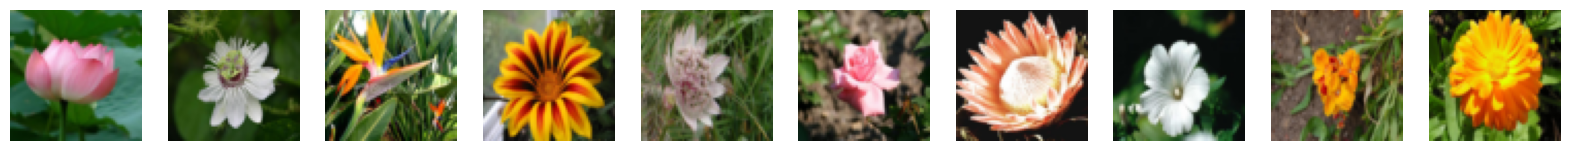

1 images shape : torch.Size([64, 3, 64, 64]), labels shape : torch.Size([64])


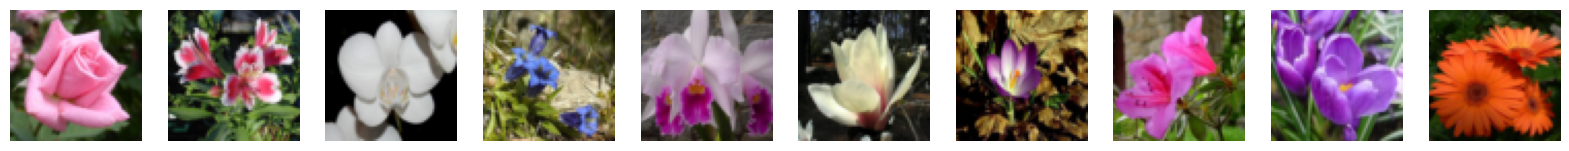

In [53]:
from notebooks.utils import display, sample_batch

for idx, (images,labels) in enumerate(train_loader):
    if idx>1:
        break
    print(f"{idx} images shape : {images.shape}, labels shape : {labels.shape}")
    display(images.permute(0,2,3,1).numpy())
    